<a href="https://colab.research.google.com/github/shh2003/Machine-Learning/blob/main/week03/WISM_CNN_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from tensorflow.keras.models import Model
import seaborn as sns
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical


In [48]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:

file_path = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"

# 3. 파일 읽기 (문제 줄 스킵 + z 뒤 세미콜론 제거)
cols = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.read_csv(
    file_path,
    header=None,
    names=cols,
    engine='python',
    on_bad_lines='skip'
)

# 4. z 컬럼 값에서 세미콜론 제거
df['z'] = df['z'].astype(str).str.replace(';', '', regex=False)

# 5. 숫자형으로 변환
df[['user', 'timestamp', 'x', 'y', 'z']] = df[['user', 'timestamp', 'x', 'y', 'z']].apply(pd.to_numeric, errors='coerce')

# 6. 확인
print(df.shape)
df.head()


(1086466, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [50]:
df.columns

Index(['user', 'activity', 'timestamp', 'x', 'y', 'z'], dtype='object')

In [51]:
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x,0
y,0
z,1


In [52]:
# NaN 값 제거
df = df.dropna()

# 확인
df.isnull().sum()


,0
user,0
activity,0
timestamp,0
x,0
y,0
z,0


In [53]:
print(df.shape)

(1086465, 6)


In [54]:
df['activity'].value_counts()

,count
activity,
Walking,418393
Jogging,336445
Upstairs,122869
Downstairs,100425
Sitting,59939
Standing,48394


In [55]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [56]:
from sklearn.preprocessing import LabelEncoder

# 1. LabelEncoder 객체 생성
le = LabelEncoder()

# 2. activity 컬럼 인코딩
df['activity_enc'] = le.fit_transform(df['activity'])

# 3. 결과 확인
print("클래스 목록:", le.classes_)
df.head()

클래스 목록: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


,user,activity,timestamp,x,y,z,activity_enc
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [57]:
from sklearn.preprocessing import StandardScaler

# 1. StandardScaler 객체 생성
scaler = StandardScaler()

# 2. x, y, z 컬럼만 표준화
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

# 3. 결과 확인
df[['x', 'y', 'z']].head()


,x,y,z
0,-0.197600,0.806331,0.022317
1,0.632345,0.596159,0.116722
2,0.616498,0.539574,-0.100695
3,-0.185715,1.669250,0.551556
4,-0.268908,0.721454,1.429807


In [58]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense

# 하이퍼파라미터
FRAME = 128   # 윈도우 길이
HOP   = 64    # 이동 간격
BATCH = 128
EPOCH = 10
SEED  = 42

In [59]:
def make_windows(df, frame=FRAME, hop=HOP):
    Xs, ys = [], []
    for _, g in df.groupby('user'):
        g = g.sort_values('timestamp')
        arr = g[['x','y','z']].to_numpy()
        lab = g['activity_enc'].to_numpy()
        for s in range(0, len(g)-frame+1, hop):
            e = s + frame
            Xs.append(arr[s:e])                                 # (frame, 3)
            ys.append(stats.mode(lab[s:e], keepdims=False)[0])  # 최빈 라벨
    return np.asarray(Xs, np.float32), np.asarray(ys, np.int64)

X, y = make_windows(df)
print(X.shape, y.shape)   # (N, FRAME, 3), (N,)
num_classes = int(y.max()) + 1


(16922, 128, 3) (16922,)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)


In [61]:
X_train.shape, X_test.shape

((13537, 128, 3), (3385, 128, 3))

In [62]:
X_train[0].shape, X_test[0].shape

((128, 3), (128, 3))

In [63]:
model = Sequential([
    Input(shape=(T, F)),
    Conv1D(64, 5, padding='same'), BatchNormalization(), Activation('relu'),
    MaxPooling1D(2, padding='same'),
    Conv1D(128, 3, padding='same'), BatchNormalization(), Activation('relu'),
    GlobalAveragePooling1D(), Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()  # 필요 없으면 지워도 됨


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 128, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,270 (106.52 KB)

 Trainable params: 26,886 (105.02 KB)

 Non-trainable params: 384 (1.50 KB)

In [64]:
hist = model.fit(
    X_train, y_train,
    epochs=EPOCH,
    batch_size=BATCH,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6053 - loss: 1.0783 - val_accuracy: 0.7264 - val_loss: 1.0347
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8139 - loss: 0.5450 - val_accuracy: 0.7493 - val_loss: 0.8694
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8526 - loss: 0.4302 - val_accuracy: 0.8468 - val_loss: 0.5489
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.8836 - loss: 0.3483 - val_accuracy: 0.9029 - val_loss: 0.3637
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.8906 - loss: 0.3184 - val_accuracy: 0.9088 - val_loss: 0.3195
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.9082 - loss: 0.2895 - val_accuracy: 0.9254 - val_loss: 0.2500
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9079 - loss: 0.2611 - val_accuracy: 0.9350 - val_loss: 0.2324
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9206 - loss: 0.2444 - val_accuracy: 0

In [65]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test | loss={loss:.4f}, acc={acc:.4f}")

y_pred = model.predict(X_test, verbose=0).argmax(1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Test | loss=0.1853, acc=0.9471
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       312
           1       0.99      0.97      0.98      1050
           2       0.98      0.96      0.97       187
           3       0.95      0.99      0.97       149
           4       0.77      0.94      0.85       383
           5       0.98      0.98      0.98      1304

    accuracy                           0.95      3385
   macro avg       0.93      0.93      0.92      3385
weighted avg       0.95      0.95      0.95      3385

[[ 226    2    0    0   71   13]
 [   5 1019    0    0   15   11]
 [   0    0  179    7    1    0]
 [   0    0    1  147    1    0]
 [  13    3    1    0  360    6]
 [   6    2    1    0   20 1275]]


In [81]:
def plot_history(history):
    plt.figure(figsize=(10, 8))
    sns.set_theme()
    # --- 정확도 ---
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], 'r-', label='Train')
    plt.plot(history.history['val_accuracy'], 'b-', label='Val')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # --- 손실 ---
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], 'r-', label='Train')
    plt.plot(history.history['val_loss'], 'b-', label='Val')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

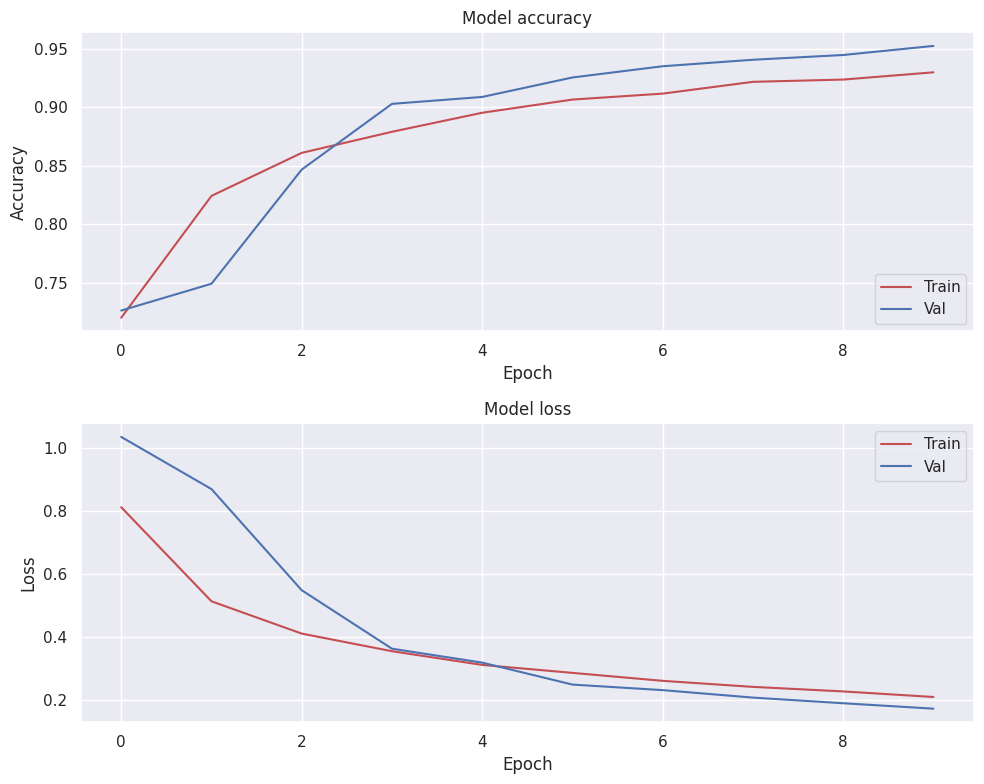

In [82]:
plot_history(hist)

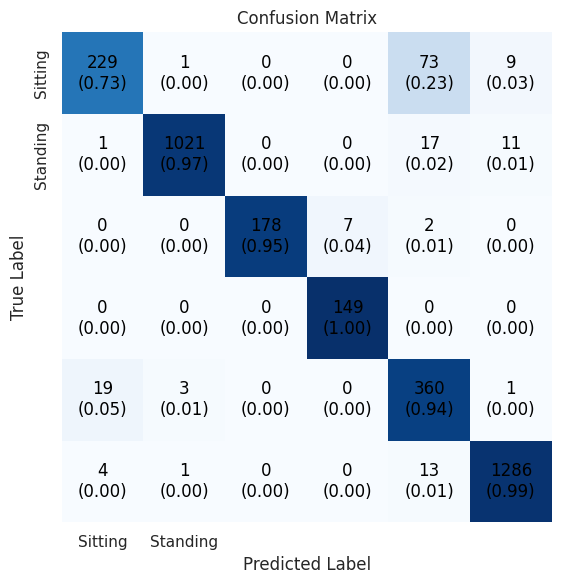

In [89]:

# 1. 모델 예측
y_pred = model.predict(X_te, verbose=0).argmax(axis=1)

# 2. 혼동행렬 계산
cm = confusion_matrix(y_te, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. 클래스 이름
class_names = ['Sitting', 'Standing']  # 실제 클래스명으로 변경 가능

# 4. 그래프 스타일 적용
sns.set_theme()  # seaborn 스타일 활성화
plt.figure(figsize=(6, 6))

# 5. heatmap 시각화
sns.heatmap(cm_percent,
            annot=False, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False, square=True)

# 6. 각 셀에 숫자 + 비율 표시
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        plt.text(j + 0.5, i + 0.5,
                 f"{count}\n({percent:.2f})",
                 ha='center', va='center', color='black', fontsize=12)

# 7. 라벨 및 제목
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()